In [1]:
# REFER FROM AWS DEMO REPO!!!
# Set up your environment according to the repo's environment.yml file or run the following...
# Comment these out, once installed or otherwise not needed.
# This creates an empty pip_requirements.txt file used to suppress 'already satisfied' output.
import os
with open('pip_requirements.txt', mode='a'): pass
%pip install boto3        -r pip_requirements.txt | grep -v 'already satisfied'
%pip install pandas       -r pip_requirements.txt | grep -v 'already satisfied'
%pip install numpy        -r pip_requirements.txt | grep -v 'already satisfied'
%pip install requests     -r pip_requirements.txt | grep -v 'already satisfied'
%pip install ipywidgets   -r pip_requirements.txt | grep -v 'already satisfied'
%pip install scikit-learn -r pip_requirements.txt | grep -v 'already satisfied'
%pip install autogluon    -r pip_requirements.txt | grep -v 'already satisfied'
%pip install matplotlib   -r pip_requirements.txt | grep -v 'already satisfied'
%pip install nbconvert    -r pip_requirements.txt | grep -v 'already satisfied'
%pip install python-dotenv    -r pip_requirements.txt | grep -v 'already satisfied'


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

In [2]:
# Import statements for packages used...
import os, glob, shutil, sys, requests, json
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from botocore import UNSIGNED
from botocore.config import Config
from io import StringIO
from datetime import datetime
from types import SimpleNamespace
from IPython.display import clear_output
from dotenv import load_dotenv
import os
from pathlib import Path
# Since __file__ is not defined in notebooks, we need to get the current notebook path
import inspect
notebook_path = inspect.getfile(inspect.currentframe())


# Add parent directory to path
sys.path.append(str(Path(notebook_path).resolve().parent.parent))

load_dotenv()

# Now you can access them
api_key = os.getenv('OPENAQ_API_KEY')

# The following is required for matplotlib plots to display in some envs...
%matplotlib inline

In [3]:
# class AQParam => Used to define attributes for the (6) main OpenAQ parameters.
class AQParam:
    def __init__(self, id, name, unit, unhealthyThresholdDefault, desc):
        self.id                        = id
        self.name                      = name
        self.unit                      = unit
        self.unhealthyThresholdDefault = unhealthyThresholdDefault
        self.desc                      = desc
    
    def isValid(self):
        if(self is not None and self.id > 0 and self.unhealthyThresholdDefault > 0.0 and 
           len(self.name) > 0 and len(self.unit) > 0 and len(self.desc) > 0):
            return True
        else:
            return False
            
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=2)

# class AQScenario => Defines an ML scenario including a Location w/ NOAA Weather Station ID 
#                     and the target OpenAQ Param.
# Note: OpenAQ data mostly begins sometime in 2016, so using that as a default yearStart value.
class AQScenario:
    def __init__(self, location=None, noaaStationID=None, aqParamTarget=None, unhealthyThreshold=None, 
                 yearStart=2016, yearEnd=2024, aqRadiusMiles=10, featureColumnsToDrop=None):
        self.location           = location
        self.name               = location + "_" + aqParamTarget.name
        self.noaaStationID      = noaaStationID
        self.noaaStationLat     = 0.0
        self.noaaStationLng     = 0.0
        self.openAqSensorIDs       = []
        
        self.aqParamTarget      = aqParamTarget
        
        if unhealthyThreshold and unhealthyThreshold > 0.0:
            self.unhealthyThreshold = unhealthyThreshold
        else:
            self.unhealthyThreshold = self.aqParamTarget.unhealthyThresholdDefault
        
        self.yearStart          = yearStart
        self.yearEnd            = yearEnd
        self.aqRadiusMiles      = aqRadiusMiles
        self.aqRadiusMeters     = aqRadiusMiles * 1610 # Rough integer approximation is fine here.
        
        self.modelFolder        = "AutogluonModels"
            
    def getSummary(self):
        return f"Scenario: {self.name} => {self.aqParamTarget.desc} ({self.aqParamTarget.name}) with UnhealthyThreshold > {self.unhealthyThreshold} {self.aqParamTarget.unit}"
    
    def getModelPath(self):
        return f"{self.modelFolder}/aq_{self.name}_{self.yearStart}-{self.yearEnd}/"
    
    def updateNoaaStationLatLng(self, noaagsod_df_row):
        # Use a NOAA row to set Lat+Lng values used for the OpenAQ API requests...
        if(noaagsod_df_row is not None and noaagsod_df_row['LATITUDE'] and noaagsod_df_row['LONGITUDE']):
            self.noaaStationLat = noaagsod_df_row['LATITUDE']
            self.noaaStationLng = noaagsod_df_row['LONGITUDE']
            print(f"NOAA Station Lat,Lng Updated for Scenario: {self.name} => {self.noaaStationLat},{self.noaaStationLng}")
        else:
            print("NOAA Station Lat,Lng COULD NOT BE UPDATED.")
    
    def isValid(self):
        if(self is not None and self.aqParamTarget is not None and
           self.yearStart > 0 and self.yearEnd > 0 and self.yearEnd >= self.yearStart and 
           self.aqRadiusMiles > 0 and self.aqRadiusMeters > 0 and self.unhealthyThreshold > 0.0 and 
           len(self.name) > 0 and len(self.noaaStationID) > 0):
            return True
        else:
            return False
            
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=2)

# class AQbyWeatherApp => Main app class with settings, AQParams, AQScenarios, and data access methods...
class AQbyWeatherApp:
    def __init__(self, mlTargetLabel='isUnhealthy', mlEvalMetric='accuracy', mlTimeLimitSecs=None):
        self.mlTargetLabel   = mlTargetLabel
        self.mlEvalMetric    = mlEvalMetric
        self.mlTimeLimitSecs = mlTimeLimitSecs
        self.mlIgnoreColumns = ['DATE','NAME','LATITUDE','LONGITUDE','day','avg']
        
        self.defaultColumnsNOAA   = ['DATE','NAME','LATITUDE','LONGITUDE',
                                     'DEWP','WDSP','MAX','MIN','PRCP','MONTH'] # Default relevant NOAA columns
        # self.defaultColumnsOpenAQ = ['summary']       # Default relevant OpenAQ columns
        
        self.aqParams    = {} # A list to save AQParam objects
        self.aqScenarios = {} # A list to save AQScenario objects
        
        self.selectedScenario = None
    
    def addAQParam(self, aqParam):
        if aqParam and aqParam.isValid():
            self.aqParams[aqParam.name] = aqParam
            return True
        else:
            return False
    
    def addAQScenario(self, aqScenario):
        if aqScenario and aqScenario.isValid():
            self.aqScenarios[aqScenario.name] = aqScenario
            if(self.selectedScenario is None):
                self.selectedScenario = self.aqScenarios[next(iter(self.aqScenarios))] # Default selectedScenario to 1st item.
            return True
        else:
            return False
    
    def getFilenameNOAA(self):
        if self and self.selectedScenario and self.selectedScenario.isValid():
            return f"dataNOAA_{self.selectedScenario.name}_{self.selectedScenario.yearStart}-{self.selectedScenario.yearEnd}_{self.selectedScenario.noaaStationID}.csv"
        else:
            return ""
    
    def getFilenameOpenAQ(self):
        if self and self.selectedScenario and self.selectedScenario.isValid() and len(self.selectedScenario.openAqSensorIDs) > 0:
            idString = ""
            for i in range(0, len(self.selectedScenario.openAqSensorIDs)):
                if i > 5:
                    break
                idString = idString + str(self.selectedScenario.openAqSensorIDs[i]) + "-"
            idString = idString[:-1]
            return f"dataOpenAQ_{self.selectedScenario.name}_{self.selectedScenario.yearStart}-{self.selectedScenario.yearEnd}_{idString}.csv"
        else:
            return ""
    
    def getFilenameOther(self, prefix):
        if self and self.selectedScenario and self.selectedScenario.isValid():
            return f"{prefix}_{self.selectedScenario.name}_{self.selectedScenario.yearStart}-{self.selectedScenario.yearEnd}.csv"
    
    def getNoaaDataFrame(self):
        # ASDI Dataset Name: NOAA GSOD
        # ASDI Dataset URL : https://registry.opendata.aws/noaa-gsod/
        # NOAA GSOD README : https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt
        # NOAA GSOD data in S3 is organized by year and Station ID values, so this is straight-forward
        # Example S3 path format => s3://noaa-gsod-pds/{yyyy}/{stationid}.csv
        # Let's start with a new DataFrame and load it from a local CSV or the NOAA data source...
        noaagsod_df = pd.DataFrame()
        filenameNOAA = self.getFilenameNOAA()

        if os.path.exists(filenameNOAA):
            # Use local data file already accessed + prepared...
            print('Loading NOAA GSOD data from local file: ', filenameNOAA)
            noaagsod_df = pd.read_csv(filenameNOAA)
        else:
            # Access + prepare data and save to a local data file...
            noaagsod_bucket = 'noaa-gsod-pds'
            print(f'Accessing and preparing data from ASDI-hosted NOAA GSOD dataset in Amazon S3 (bucket: {noaagsod_bucket})...')
            s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

            for year in range(self.selectedScenario.yearStart, self.selectedScenario.yearEnd + 1):
                key = f'{year}/{self.selectedScenario.noaaStationID}.csv'                                    # Compute the key to get
                csv_obj = s3.get_object(Bucket=noaagsod_bucket, Key=key)                                     # Get the S3 object
                csv_string = csv_obj['Body'].read().decode('utf-8')                                          # Read object contents to a string
                noaagsod_df = pd.concat([noaagsod_df, pd.read_csv(StringIO(csv_string))], ignore_index=True) # Use the string to build the DataFrame

            # It may be true that Month affects air quality (ie: seasonal considerations; tends to have correlation for certain areas)
            # Extract date components for seasonality
            noaagsod_df['MONTH'] = pd.to_datetime(noaagsod_df['DATE']).dt.month
            noaagsod_df['DAYOFWEEK'] = pd.to_datetime(noaagsod_df['DATE']).dt.dayofweek
            noaagsod_df['SEASON'] = pd.to_datetime(noaagsod_df['DATE']).dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 
                                                                                      4: 'Spring', 5: 'Spring', 6: 'Summer',
                                                                                      7: 'Summer', 8: 'Summer', 9: 'Fall', 
                                                                                      10: 'Fall', 11: 'Fall', 12: 'Winter'})
            
            # Calculate temperature differences and averages
            noaagsod_df['TEMP_RANGE'] = noaagsod_df['MAX'] - noaagsod_df['MIN']
            noaagsod_df['TEMP_AVG'] = (noaagsod_df['MAX'] + noaagsod_df['MIN']) / 2
            
            # Create interaction features
            noaagsod_df['TEMP_DEWP_DIFF'] = noaagsod_df['TEMP_AVG'] - noaagsod_df['DEWP']
            noaagsod_df['WDSP_TEMP'] = noaagsod_df['WDSP'] * noaagsod_df['TEMP_AVG']

            # Trim down to the desired key columns... (do this last in case engineered columns are to be removed)
            # noaagsod_df = noaagsod_df[self.defaultColumnsNOAA]
            
        return noaagsod_df
        
    def getOpenAqDataFrame(self):
        # ASDI Dataset Name: OpenAQ
        # ASDI Dataset URL : https://registry.opendata.aws/openaq/
        # OpenAQ API Docs  : https://docs.openaq.org/
        # OpenAQ S3 data is only organized by date folders, so each folder is large and contains all stations.
        # Because of this, it's better to query ASDI OpenAQ data using the CloudFront-hosted API.
        # Note that some days may not have values and will get filtered out via an INNER JOIN later.
        # Let's start with a new DataFrame and load it from a local CSV or the NOAA data source...
        aq_df = pd.DataFrame()
        aq_reqUrlBase = "https://api.openaq.org/v3" # OpenAQ ASDI API Endpoint URL Base
        print(f"API Key: {api_key}")
        headers = {
            'accept': 'application/json',
            'x-api-key': api_key
        }

        if self.selectedScenario.noaaStationLat == 0.0 or self.selectedScenario.noaaStationLng == 0.0:
            print("NOAA Station Lat/Lng NOT DEFINED. CANNOT PROCEED")
            return aq_df
        
        if len(self.selectedScenario.openAqSensorIDs) == 0:
            # Find OpenAQ sensors near the NOAA station location
            print('Finding OpenAQ sensors near NOAA station location...')
            
            # Query OpenAQ locations API with coordinates
            aq_reqParams = {
                'coordinates': f"{self.selectedScenario.noaaStationLat},{self.selectedScenario.noaaStationLng}",
                'radius': 25000, # 25km radius
                'parameter': self.selectedScenario.aqParamTarget.name,
                'limit': 100
            }
            
            aq_resp = requests.get(aq_reqUrlBase + "/locations", params=aq_reqParams, headers=headers)
            aq_data = aq_resp.json()
            
            if 'results' in aq_data:
                for location in aq_data['results']:
                    # Check each location's sensors for our target parameter
                    for sensor in location['sensors']:
                        if sensor['parameter']['name'] == self.selectedScenario.aqParamTarget.name:
                            self.selectedScenario.openAqSensorIDs.append(sensor['id'])
                            break # Only need one sensor per location
                            
            print(f'Found {len(self.selectedScenario.openAqSensorIDs)} OpenAQ locations with {self.selectedScenario.aqParamTarget.name} sensors')
        
        if len(self.selectedScenario.openAqSensorIDs) >= 1:
            filenameOpenAQ = self.getFilenameOpenAQ()

            if os.path.exists(filenameOpenAQ):
                # Use local data file already accessed + prepared...
                print('Loading OpenAQ data from local file: ', filenameOpenAQ)
                aq_df = pd.read_csv(filenameOpenAQ)
            else:
                # Access + prepare data (NOTE: calling OpenAQ API one year at a time to avoid timeouts)
                print('Accessing ASDI-hosted OpenAQ Measurements (HTTPS API)...')
                
                for year in range(self.selectedScenario.yearStart, self.selectedScenario.yearEnd + 1):
                    for sensor_id in self.selectedScenario.openAqSensorIDs:
                        # Get daily measurements for this sensor and year
                        aq_reqUrl = f"{aq_reqUrlBase}/sensors/{sensor_id}/days"
                        aq_reqParams = {
                            'date_from': f'{year}-01-01',
                            'date_to': f'{year}-12-31',
                            'limit': 366
                        }
                        
                        print(f'Fetching data for sensor {sensor_id} in {year}')
                        aq_resp = requests.get(aq_reqUrl, params=aq_reqParams, headers=headers)
                        aq_data = aq_resp.json()
                        
                        if 'results' in aq_data:
                            for measurement in aq_data['results']:
                                dt = datetime.strptime(measurement['period']['datetimeFrom']['utc'], '%Y-%m-%dT%H:%M:%SZ')
                                if measurement['value'] is not None:
                                    date_df = pd.DataFrame({'day': [dt.date()], 'avg': [measurement['value']]})
                                    aq_df = pd.concat([aq_df, date_df], ignore_index=True)

                # Group by day and calculate daily averages
                if not aq_df.empty:
                    aq_df = aq_df.groupby('day')['avg'].mean().reset_index()

                # Perform some Label Engineering to add our binary classification label => {0=OKAY, 1=UNHEALTHY}
                if not aq_df.empty:
                    aq_df[self.mlTargetLabel] = np.where(aq_df['avg'] <= self.selectedScenario.unhealthyThreshold, 0, 1)
        
        return aq_df
    
    def getMergedDataFrame(self, noaagsod_df, aq_df):
        if len(noaagsod_df) > 0 and len(aq_df) > 0:
            # Print shapes before merge to debug
            print(f"NOAA GSOD shape before merge: {noaagsod_df.shape}")
            print(f"AQ data shape before merge: {aq_df.shape}")
            print("\nNOAA GSOD sample:")
            print(noaagsod_df.head())
            print("\nAQ data sample:")
            print(aq_df.head())
            
            merged_df = pd.merge(noaagsod_df, aq_df, how="inner", left_on="DATE", right_on="day")
            
            # Print shape after merge to see if rows were lost
            print(f"\nMerged shape: {merged_df.shape}")
            
            if len(merged_df) == 0:
                print("\nMerge resulted in empty DataFrame. This means there are no matching dates between the two datasets.")
                print("Check that DATE and day columns have the same format (both should be datetime or string)")
                print(f"DATE dtype: {noaagsod_df['DATE'].dtype}")
                print(f"day dtype: {aq_df['day'].dtype}")
            
            display(merged_df)
            merged_df = merged_df.drop(columns=self.mlIgnoreColumns)
            return merged_df
        else:
            return pd.DataFrame()
    
    def getConfusionMatrixData(self, cm):
        cmData = SimpleNamespace()
        cmData.TN = cm[0][0]
        cmData.TP = cm[1][1]
        cmData.FN = cm[1][0]
        cmData.FP = cm[0][1]
        
        cmData.TN_Rate = cmData.TN/(cmData.TN+cmData.FP)
        cmData.TP_Rate = cmData.TP/(cmData.TP+cmData.FN)
        cmData.FN_Rate = cmData.FN/(cmData.FN+cmData.TP)
        cmData.FP_Rate = cmData.FP/(cmData.FP+cmData.TN)
        
        cmData.TN_Output = f"True Negatives  (TN): {cmData.TN} of {cmData.TN+cmData.FP} => {round(cmData.TN_Rate * 100, 2)}%"
        cmData.TP_Output = f"True Positives  (TP): {cmData.TP} of {cmData.TP+cmData.FN} => {round(cmData.TP_Rate * 100, 2)}%"
        cmData.FN_Output = f"False Negatives (FN): {cmData.FN} of {cmData.FN+cmData.TP} => {round(cmData.FN_Rate * 100, 2)}%"
        cmData.FP_Output = f"False Positives (FP): {cmData.FP} of {cmData.FP+cmData.TN} => {round(cmData.FP_Rate * 100, 2)}%"
        
        return cmData
            
print("Classes and Variables are ready.")

Classes and Variables are ready.


In [4]:
# CELL #4: Review the pre-defined AQParams and AQScenarios in this cell. You can edit these and/or use your own...
# AQParams are added with default thresholds, which can be overridden on a per-AQScenario basis.
# These AQParams are based on the OpenAQ /parameters API call where isCore=true (https://api.openaq.org/v2/parameters).
# Default thresholds where provided using data from EPA.gov (https://www.epa.gov/criteria-air-pollutants/naaqs-table).
# Confirm and adjust params or thresholds as needed for your needs... Not for scientific or health purposes.

# Instantiate main App class with explicit mlTargetLabel and mlEvalMetric provided...
AQbyWeather = AQbyWeatherApp(mlTargetLabel='isUnhealthy', mlEvalMetric='accuracy', mlTimeLimitSecs=120)

# Define and add new AQParams...
AQbyWeather.addAQParam(AQParam( 1, "pm10", "µg/m³", 150.0, "Particulate Matter < 10 micrometers"))
AQbyWeather.addAQParam(AQParam( 2, "pm25", "µg/m³",  12.0, "Particulate Matter < 2.5 micrometers"))
AQbyWeather.addAQParam(AQParam( 7, "no2",  "ppm",   100.0, "Nitrogen Dioxide"))
AQbyWeather.addAQParam(AQParam( 8, "co",   "ppm",     9.0, "Carbon Monoxide"))
AQbyWeather.addAQParam(AQParam( 9, "so2",  "ppm",    75.0, "Sulfur Dioxide"))
AQbyWeather.addAQParam(AQParam(10, "o3",   "ppm",   0.070, "Ground Level Ozone"))

# Define available AQ Scenarios for certain locations with their associated NOAA GSOD StationID values...
# NOAA GSOD Station Search: https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-day
# TODO: Someday consider how to OPTIONALLY append more scenarios via an optional JSON file
#       (ie: without adding a dependecy outside the .ipynb file)
# NOTE: For Ozone Scenarios, we're generally using 0.035 ppm to override the default threshold.
AQbyWeather.addAQScenario(AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["pm10"], None)) # Attempt at pm10 prediction.
AQbyWeather.addAQScenario(AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("fresno",      "72389093193", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("fresno",      "72389093193", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("visalia",     "72389693144", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("visalia",     "72389693144", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("san-jose",    "72494693232", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("san-jose",    "72494693232", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("los-angeles", "72287493134", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("los-angeles", "72287493134", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("phoenix",     "72278023183", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("phoenix",     "72278023183", AQbyWeather.aqParams["o3"],  0.035))
AQbyWeather.addAQScenario(AQScenario("fairbanks",   "70261026411", AQbyWeather.aqParams["pm25"], None))
AQbyWeather.addAQScenario(AQScenario("lahore-pk",   "41640099999", AQbyWeather.aqParams["pm25"], None))

print(f"AQbyWeather.aqParams: {str(len(AQbyWeather.aqParams))}")
print(f"AQbyWeather.aqScenarios: {str(len(AQbyWeather.aqScenarios))} (Default Selected: {AQbyWeather.selectedScenario.name})")

AQbyWeather.aqParams: 6
AQbyWeather.aqScenarios: 15 (Default Selected: bakersfield_pm25)


In [5]:
# CELL #5: Select a Scenario via DROP DOWN LIST to use throughout the Notebook. This will drive the ML process...
# A default "value" is set to avoid issues. Change this default to run the Notebook from start-to-finish for that Scenario.
print("*** CHOOSE YOUR OWN ADVENTURE HERE ***")
print("Please select a Scenario via the following drop-down-list...")
print("(NOTE: If you change Scenario, you must re-run remaining cells to see changes.)")
ddl = widgets.Dropdown(options=AQbyWeather.aqScenarios.keys(), 
                       value=AQbyWeather.aqScenarios["los-angeles_pm25"].name) # <-- DEFAULT / FULL-RUN VALUE
ddl

*** CHOOSE YOUR OWN ADVENTURE HERE ***
Please select a Scenario via the following drop-down-list...
(NOTE: If you change Scenario, you must re-run remaining cells to see changes.)


Dropdown(index=9, options=('bakersfield_pm25', 'bakersfield_pm10', 'bakersfield_o3', 'fresno_pm25', 'fresno_o3…

In [6]:
if ddl.value:
    AQbyWeather.selectedScenario = AQbyWeather.aqScenarios[ddl.value]
    print(AQbyWeather.selectedScenario.getSummary())
    print(AQbyWeather.selectedScenario.toJSON())
else:
    print("Please select a Scenario via the above drop-down-list.")

Scenario: los-angeles_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
{
  "aqParamTarget": {
    "desc": "Particulate Matter < 2.5 micrometers",
    "id": 2,
    "name": "pm25",
    "unhealthyThresholdDefault": 12.0,
    "unit": "\u00b5g/m\u00b3"
  },
  "aqRadiusMeters": 16100,
  "aqRadiusMiles": 10,
  "location": "los-angeles",
  "modelFolder": "AutogluonModels",
  "name": "los-angeles_pm25",
  "noaaStationID": "72287493134",
  "noaaStationLat": 0.0,
  "noaaStationLng": 0.0,
  "openAqSensorIDs": [],
  "unhealthyThreshold": 12.0,
  "yearEnd": 2024,
  "yearStart": 2016
}


In [7]:
# GET NOAA GSOD WEATHER DATA...
print(AQbyWeather.selectedScenario.getSummary())
noaagsod_df = AQbyWeather.getNoaaDataFrame()

if(len(noaagsod_df) >= 1):
    # Update NOAA Station Lat/Lng...
    AQbyWeather.selectedScenario.updateNoaaStationLatLng(noaagsod_df.iloc[0])
    
    # Save DataFrame to CSV...
    noaagsod_df.to_csv(AQbyWeather.getFilenameNOAA(), index=False)

    # Output DataFrame properties...
    print('noaagsod_df.shape =', noaagsod_df.shape)
    display(noaagsod_df)

Scenario: los-angeles_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Loading NOAA GSOD data from local file:  dataNOAA_los-angeles_pm25_2016-2024_72287493134.csv
NOAA Station Lat,Lng Updated for Scenario: los-angeles_pm25 => 34.0236,-118.2911
noaagsod_df.shape = (3061, 35)


,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,TEMP,TEMP_ATTRIBUTES,DEWP,DEWP_ATTRIBUTES,...,PRCP_ATTRIBUTES,SNDP,FRSHTT,MONTH,DAYOFWEEK,SEASON,TEMP_RANGE,TEMP_AVG,TEMP_DEWP_DIFF,WDSP_TEMP
0,72287493134,2016-01-01,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",52.7,24,19.1,24,...,G,999.9,0,1,4,Winter,23.9,52.95,33.85,84.720
1,72287493134,2016-01-02,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",54.8,24,20.1,24,...,G,999.9,0,1,5,Winter,21.9,53.95,33.85,113.295
2,72287493134,2016-01-03,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",52.6,24,38.2,24,...,G,999.9,0,1,6,Winter,20.8,54.50,16.30,38.150
3,72287493134,2016-01-04,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",59.3,24,44.1,24,...,G,999.9,10000,1,0,Winter,25.0,56.60,12.50,62.260
4,72287493134,2016-01-05,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",57.4,24,51.9,24,...,G,999.9,110000,1,1,Winter,15.1,61.55,9.65,129.255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056,72287493134,2024-05-16,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",62.9,24,53.2,24,...,G,999.9,10000,5,3,Spring,7.9,64.05,10.85,51.240
3057,72287493134,2024-05-17,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",63.2,24,53.8,24,...,G,999.9,0,5,4,Spring,9.0,64.60,10.80,58.140
3058,72287493134,2024-05-18,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",62.9,24,53.5,24,...,G,999.9,0,5,5,Spring,10.1,64.05,10.55,83.265
3059,72287493134,2024-05-19,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",62.9,24,52.1,24,...,G,999.9,0,5,6,Spring,13.0,65.50,13.40,91.700


In [8]:
# GET OPENAQ AIR QUALITY DAILY AVERAGES DATA...
print(AQbyWeather.selectedScenario.getSummary())
aq_df = AQbyWeather.getOpenAqDataFrame() # Gets nearby Location IDs THEN gets associated daily averages.
print(aq_df)

if len(aq_df) > 0:
    # Output DataFrame properties...
    print('aq_df.shape =', aq_df.shape)
    display(aq_df)
    aq_df.to_csv(AQbyWeather.getFilenameOpenAQ(), index=False)

Scenario: los-angeles_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
API Key: 49c492bb9d9e24d5e78ae75b2034430080bc132bcd7c9dfa3f2b08fabda35a9d
Finding OpenAQ sensors near NOAA station location...
Found 90 OpenAQ locations with pm25 sensors
Loading OpenAQ data from local file:  dataOpenAQ_los-angeles_pm25_2016-2024_2775-25551-15731-25196-24000-1654141.csv
             day        avg  isUnhealthy
0     2016-03-06   8.000000            0
1     2016-03-07   4.500000            0
2     2016-03-10  15.000000            1
3     2016-03-11   9.080000            0
4     2016-03-12   7.860000            0
...          ...        ...          ...
2339  2024-12-27  15.662807            1
2340  2024-12-28  22.475439            1
2341  2024-12-29  24.024561            1
2342  2024-12-30  25.638596            1
2343  2024-12-31  30.856140            1

[2344 rows x 3 columns]
aq_df.shape = (2344, 3)


,day,avg,isUnhealthy
0,2016-03-06,8.000000,0
1,2016-03-07,4.500000,0
2,2016-03-10,15.000000,1
3,2016-03-11,9.080000,0
4,2016-03-12,7.860000,0
...,...,...,...
2339,2024-12-27,15.662807,1
2340,2024-12-28,22.475439,1
2341,2024-12-29,24.024561,1
2342,2024-12-30,25.638596,1


Scenario: los-angeles_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
NOAA GSOD data shape: (3061, 35)

NOAA GSOD sample dates:
0    2016-01-01
1    2016-01-02
2    2016-01-03
3    2016-01-04
4    2016-01-05
Name: DATE, dtype: object
['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'TEMP', 'TEMP_ATTRIBUTES', 'DEWP', 'DEWP_ATTRIBUTES', 'SLP', 'SLP_ATTRIBUTES', 'STP', 'STP_ATTRIBUTES', 'VISIB', 'VISIB_ATTRIBUTES', 'WDSP', 'WDSP_ATTRIBUTES', 'MXSPD', 'GUST', 'MAX', 'MAX_ATTRIBUTES', 'MIN', 'MIN_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SNDP', 'FRSHTT', 'MONTH', 'DAYOFWEEK', 'SEASON', 'TEMP_RANGE', 'TEMP_AVG', 'TEMP_DEWP_DIFF', 'WDSP_TEMP']

OpenAQ data shape: (2344, 3)

OpenAQ sample dates:
0    2016-03-06
1    2016-03-07
2    2016-03-10
3    2016-03-11
4    2016-03-12
Name: day, dtype: object

NOAA date type: object
OpenAQ date type: object
NOAA date type: object
NOAA GSOD shape before merge: (3061, 35)
AQ data shape before merge: 

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,TEMP,TEMP_ATTRIBUTES,DEWP,DEWP_ATTRIBUTES,...,MONTH,DAYOFWEEK,SEASON,TEMP_RANGE,TEMP_AVG,TEMP_DEWP_DIFF,WDSP_TEMP,day,avg,isUnhealthy
0,72287493134,2016-03-06,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",61.1,24,53.8,24,...,3,6,Spring,11.0,61.40,7.60,239.460,2016-03-06,8.000000,0
1,72287493134,2016-03-07,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",55.9,24,45.2,24,...,3,0,Spring,20.0,56.90,11.70,147.940,2016-03-07,4.500000,0
2,72287493134,2016-03-10,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",63.2,23,52.2,23,...,3,3,Spring,23.9,65.05,12.85,58.545,2016-03-10,15.000000,1
3,72287493134,2016-03-11,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",61.1,24,53.0,24,...,3,4,Spring,25.0,64.50,11.50,135.450,2016-03-11,9.080000,0
4,72287493134,2016-03-12,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",55.8,24,43.7,24,...,3,5,Spring,22.2,58.00,14.30,104.400,2016-03-12,7.860000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114,72287493134,2024-05-16,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",62.9,24,53.2,24,...,5,3,Spring,7.9,64.05,10.85,51.240,2024-05-16,8.225789,0
2115,72287493134,2024-05-17,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",63.2,24,53.8,24,...,5,4,Spring,9.0,64.60,10.80,58.140,2024-05-17,8.358421,0
2116,72287493134,2024-05-18,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",62.9,24,53.5,24,...,5,5,Spring,10.1,64.05,10.55,83.265,2024-05-18,8.244386,0
2117,72287493134,2024-05-19,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US",62.9,24,52.1,24,...,5,6,Spring,13.0,65.50,13.40,91.700,2024-05-19,7.848070,0



Merged data shape: (2119, 32)
merged_df.shape = (2119, 32)


,STATION,ELEVATION,TEMP,TEMP_ATTRIBUTES,DEWP,DEWP_ATTRIBUTES,SLP,SLP_ATTRIBUTES,STP,STP_ATTRIBUTES,...,SNDP,FRSHTT,MONTH,DAYOFWEEK,SEASON,TEMP_RANGE,TEMP_AVG,TEMP_DEWP_DIFF,WDSP_TEMP,isUnhealthy
0,72287493134,54.6,61.1,24,53.8,24,1015.5,18,8.8,24,...,999.9,10000,3,6,Spring,11.0,61.40,7.60,239.460,0
1,72287493134,54.6,55.9,24,45.2,24,1012.6,22,5.9,24,...,999.9,10000,3,0,Spring,20.0,56.90,11.70,147.940,0
2,72287493134,54.6,63.2,23,52.2,23,1016.6,23,10.2,16,...,999.9,0,3,3,Spring,23.9,65.05,12.85,58.545,1
3,72287493134,54.6,61.1,24,53.0,24,1015.5,22,8.9,24,...,999.9,110000,3,4,Spring,25.0,64.50,11.50,135.450,0
4,72287493134,54.6,55.8,24,43.7,24,1018.7,24,12.0,24,...,999.9,0,3,5,Spring,22.2,58.00,14.30,104.400,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114,72287493134,54.6,62.9,24,53.2,24,1014.2,22,7.6,24,...,999.9,10000,5,3,Spring,7.9,64.05,10.85,51.240,0
2115,72287493134,54.6,63.2,24,53.8,24,1014.5,23,8.0,24,...,999.9,0,5,4,Spring,9.0,64.60,10.80,58.140,0
2116,72287493134,54.6,62.9,24,53.5,24,1015.0,24,8.6,24,...,999.9,0,5,5,Spring,10.1,64.05,10.55,83.265,0
2117,72287493134,54.6,62.9,24,52.1,24,1016.8,24,10.3,24,...,999.9,0,5,6,Spring,13.0,65.50,13.40,91.700,0


,STATION,ELEVATION,TEMP,TEMP_ATTRIBUTES,DEWP,DEWP_ATTRIBUTES,SLP,SLP_ATTRIBUTES,STP,STP_ATTRIBUTES,...,SNDP,FRSHTT,MONTH,DAYOFWEEK,SEASON,TEMP_RANGE,TEMP_AVG,TEMP_DEWP_DIFF,WDSP_TEMP,isUnhealthy
0,72287493134,54.6,61.1,24,53.8,24,1015.5,18,8.8,24,...,999.9,10000,3,6,Spring,11.0,61.40,7.60,239.460,0
1,72287493134,54.6,55.9,24,45.2,24,1012.6,22,5.9,24,...,999.9,10000,3,0,Spring,20.0,56.90,11.70,147.940,0
2,72287493134,54.6,63.2,23,52.2,23,1016.6,23,10.2,16,...,999.9,0,3,3,Spring,23.9,65.05,12.85,58.545,1
3,72287493134,54.6,61.1,24,53.0,24,1015.5,22,8.9,24,...,999.9,110000,3,4,Spring,25.0,64.50,11.50,135.450,0
4,72287493134,54.6,55.8,24,43.7,24,1018.7,24,12.0,24,...,999.9,0,3,5,Spring,22.2,58.00,14.30,104.400,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114,72287493134,54.6,62.9,24,53.2,24,1014.2,22,7.6,24,...,999.9,10000,5,3,Spring,7.9,64.05,10.85,51.240,0
2115,72287493134,54.6,63.2,24,53.8,24,1014.5,23,8.0,24,...,999.9,0,5,4,Spring,9.0,64.60,10.80,58.140,0
2116,72287493134,54.6,62.9,24,53.5,24,1015.0,24,8.6,24,...,999.9,0,5,5,Spring,10.1,64.05,10.55,83.265,0
2117,72287493134,54.6,62.9,24,52.1,24,1016.8,24,10.3,24,...,999.9,0,5,6,Spring,13.0,65.50,13.40,91.700,0


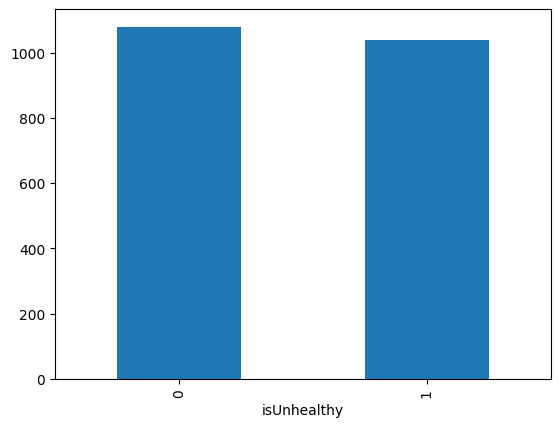

In [9]:
# Merge the NOAA GSOD weather data with our OpenAQ data by DATE...
# Perform another column drop to remove columns we don't want as features/inputs.
# This column removal will NOT be necessary once we can use Autogluon ignore_columns param (TBD).
print(AQbyWeather.selectedScenario.getSummary())
# Debug merge operation
print("NOAA GSOD data shape:", noaagsod_df.shape)
print("\nNOAA GSOD sample dates:")
print(noaagsod_df['DATE'].head())
print(noaagsod_df.columns.tolist())   # list of all column names

print("\nOpenAQ data shape:", aq_df.shape) 
print("\nOpenAQ sample dates:")
print(aq_df['day'].head())

# Check for date format consistency
print("\nNOAA date type:", noaagsod_df['DATE'].dtype)
# Convert dates to string type
noaagsod_df['DATE'] = noaagsod_df['DATE'].astype(str)
aq_df['day'] = aq_df['day'].astype(str)
print("OpenAQ date type:", aq_df['day'].dtype)
print("NOAA date type:", noaagsod_df['DATE'].dtype)

# Attempt merge with debug info
merged_df = AQbyWeather.getMergedDataFrame(noaagsod_df, aq_df)
print("\nMerged data shape:", merged_df.shape)
if(len(merged_df) > 0):
    # Output DataFrame properties...
    print('merged_df.shape =', merged_df.shape)
    display(merged_df)
    merged_df.groupby([AQbyWeather.mlTargetLabel]).size().plot(kind="bar")
    merged_df.to_csv(AQbyWeather.getFilenameOther("dataMERGED"), index=False)

display(merged_df)

In [10]:
from autogluon.features.generators import PipelineFeatureGenerator, CategoryFeatureGenerator, IdentityFeatureGenerator
from autogluon.common.features.types import R_INT, R_FLOAT
from autogluon.features.generators import AutoMLPipelineFeatureGenerator

columns_to_drop=['MIN_ATTRIBUTES', 'MAX_ATTRIBUTES']
merged_df = merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns])

merged_df = merged_df.replace(r'^\s*$', np.nan, regex=True)

auto_ml_pipeline_feature_generator = AutoMLPipelineFeatureGenerator()
merged_df = auto_ml_pipeline_feature_generator.fit_transform(X=merged_df)

print("\nColumn dtypes:")
print(merged_df.dtypes)

# Display basic statistics of the merged dataframe
print("\nDataset Statistics:")
print("\nShape:", merged_df.shape)
print("\nColumns:", merged_df.columns.tolist())
print("\nData Types:")
print(merged_df.dtypes)
print("\nSummary Statistics:")
print(merged_df.describe())
print("\nMissing Values:")
print(merged_df.isnull().sum())
print("\nValue Counts for Target Variable 'isUnhealthy':")
print(merged_df['isUnhealthy'].value_counts())




Column dtypes:
TEMP                 float64
TEMP_ATTRIBUTES        int64
DEWP                 float64
DEWP_ATTRIBUTES        int64
SLP                  float64
SLP_ATTRIBUTES         int64
STP                  float64
STP_ATTRIBUTES         int64
VISIB                float64
VISIB_ATTRIBUTES       int64
WDSP                 float64
WDSP_ATTRIBUTES        int64
MXSPD                float64
GUST                 float64
MAX                  float64
MIN                  float64
PRCP                 float64
FRSHTT                 int64
MONTH                  int64
DAYOFWEEK              int64
TEMP_RANGE           float64
TEMP_AVG             float64
TEMP_DEWP_DIFF       float64
WDSP_TEMP            float64
isUnhealthy             int8
PRCP_ATTRIBUTES     category
SEASON              category
dtype: object

Dataset Statistics:

Shape: (2119, 27)

Columns: ['TEMP', 'TEMP_ATTRIBUTES', 'DEWP', 'DEWP_ATTRIBUTES', 'SLP', 'SLP_ATTRIBUTES', 'STP', 'STP_ATTRIBUTES', 'VISIB', 'VISIB_ATTRIBUTES', 'WD

Scenario: los-angeles_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


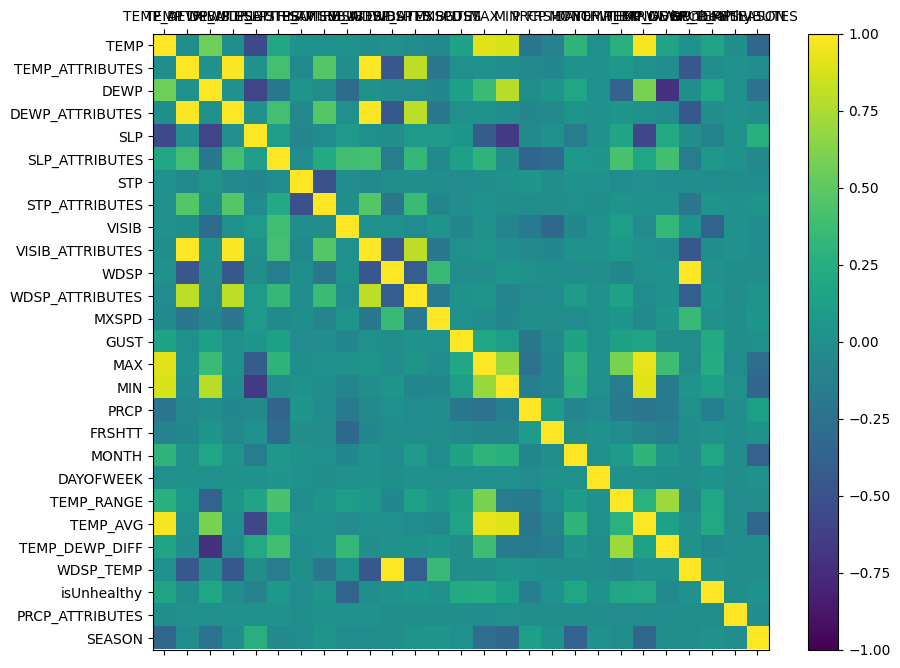

In [11]:
# Visualize correlations in our merged dataframe...
print(AQbyWeather.selectedScenario.getSummary())
correlations = merged_df.corr()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(merged_df.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(merged_df.columns)
ax.set_yticklabels(merged_df.columns)
plt.show()

In [12]:
# Additional import statements for autogluon+sklearn and split out train_df + validate_df data...
print(AQbyWeather.selectedScenario.getSummary())
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
train_df, validate_df = train_test_split(merged_df, test_size=0.25, random_state=1)
print('Number of training samples:', len(train_df))
print('Number of validation samples:', len(validate_df))

Scenario: los-angeles_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Number of training samples: 1589
Number of validation samples: 530


In [13]:
# Create the test_df data and remove the target label column...
print(AQbyWeather.selectedScenario.getSummary())
test_df=validate_df.drop([AQbyWeather.mlTargetLabel], axis=1)
display(test_df)

Scenario: los-angeles_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


,TEMP,TEMP_ATTRIBUTES,DEWP,DEWP_ATTRIBUTES,SLP,SLP_ATTRIBUTES,STP,STP_ATTRIBUTES,VISIB,VISIB_ATTRIBUTES,...,PRCP,FRSHTT,MONTH,DAYOFWEEK,TEMP_RANGE,TEMP_AVG,TEMP_DEWP_DIFF,WDSP_TEMP,PRCP_ATTRIBUTES,SEASON
1208,63.2,24,52.0,24,1017.3,24,10.8,24,10.0,24,...,0.0,0,10,5,15.2,63.50,11.50,76.200,1,0
447,73.2,24,62.7,24,1012.4,23,5.9,24,7.2,24,...,0.0,0,8,6,20.0,74.90,12.20,134.820,0,2
1460,66.0,24,52.8,24,1011.3,24,4.8,24,10.0,24,...,0.0,0,6,5,16.9,67.45,14.65,107.920,0,2
1503,75.0,24,62.9,24,1014.2,24,7.9,24,10.0,24,...,0.0,0,7,6,20.0,76.00,13.10,83.600,0,2
1219,60.8,24,49.4,24,1017.8,24,11.2,24,10.0,24,...,0.0,0,10,2,18.0,62.10,12.70,80.730,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,73.3,24,59.6,23,1011.5,24,5.2,24,7.0,24,...,0.0,0,8,2,24.2,77.00,17.40,115.500,0,2
385,66.7,24,57.0,24,1013.5,24,6.9,24,8.8,24,...,0.0,0,5,1,21.9,71.05,14.05,113.680,0,1
1256,60.0,24,21.2,24,1020.9,24,14.3,24,10.0,24,...,0.0,0,11,4,29.0,61.40,40.20,36.840,0,0
2055,62.3,24,49.1,24,1017.0,24,10.4,24,10.0,24,...,0.0,0,3,0,23.0,63.50,14.40,76.200,0,1


In [14]:
from autogluon.common import space

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 50,  # number of training epochs (controls training time of NN models)
    'learning_rate': space.Real(1e-4, 1e-2, default=1e-3, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

num_trials = 10  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler
time_limit = 60 * 60
hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}  # Refer to TabularPredictor.fit docstring for all valid values


In [15]:
# Use AutoGluon TabularPredictor to fit a model for our training data...
display(AQbyWeather.selectedScenario.getSummary()) #Using display for consistent/sequential output order.
predictor = TabularPredictor(label=AQbyWeather.mlTargetLabel, 
                             eval_metric=AQbyWeather.mlEvalMetric, 
                             path=AQbyWeather.selectedScenario.getModelPath())
predictor.fit(train_data=train_df, auto_stack=True, time_limit=time_limit, hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs, verbosity=3, presets='best_quality')

2025-05-19 16:34:42,678	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/changliang.wu/Projects/aws/aqi/aqi_prediction/notebooks/AutogluonModels/aq_los-angeles_pm25_2016-2024/models/NeuralNetTorch_BAG_L1' in 0.0093s.
2025-05-19 16:34:42,688	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 10 trial(s):
- 4b934db0: FileNotFoundError('Could not fetch metrics for 4b934db0: both result.json and progress.csv were not found at /Users/changliang.wu/Projects/aws/aqi/aqi_prediction/notebooks/AutogluonModels/aq_los-angeles_pm25_2016-2024/models/NeuralNetTorch_BAG_L1/4b934db0')
- 50bcc941: FileNotFoundError('Could not fetch metrics for 50bcc941: both result.json and progress.csv were not found at /Users/changliang.wu/Projects/aws/aqi/aqi_prediction/notebooks/AutogluonModels/aq_los-angeles_pm25_2016-2024/models/NeuralNetTorch_BAG_L1/50bcc941')
- 1e03893b: FileNotFoundError('Could not fetch metrics for 1e03893b: both result.json and p

In [16]:
# Get dataframes for feature importance + model leaderboard AND get+display model evaluation...
display(AQbyWeather.selectedScenario.getSummary()) #Using display for consistent/sequential output order.
featureimp_df   = predictor.feature_importance(validate_df)
leaderboard_df  = predictor.leaderboard(validate_df, silent=True)
modelEvaluation = predictor.evaluate(validate_df, auxiliary_metrics=True)

'Scenario: los-angeles_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³'

Loading: /Users/changliang.wu/Projects/aws/aqi/aqi_prediction/notebooks/AutogluonModels/aq_los-angeles_pm25_2016-2024/models/WeightedEnsemble_L2/model.pkl
Computing feature importance via permutation shuffling for 26 features using 530 rows with 5 shuffle sets...
Loading: /Users/changliang.wu/Projects/aws/aqi/aqi_prediction/notebooks/AutogluonModels/aq_los-angeles_pm25_2016-2024/models/LightGBM_BAG_L1/T8/model.pkl
Loading: /Users/changliang.wu/Projects/aws/aqi/aqi_prediction/notebooks/AutogluonModels/aq_los-angeles_pm25_2016-2024/models/NeuralNetTorch_BAG_L1/b00e46f8/model.pkl
Loading: /Users/changliang.wu/Projects/aws/aqi/aqi_prediction/notebooks/AutogluonModels/aq_los-angeles_pm25_2016-2024/models/WeightedEnsemble_L2/model.pkl
	26.39s	= Expected runtime (5.28s per shuffle set)
Loading: /Users/changliang.wu/Projects/aws/aqi/aqi_prediction/notebooks/AutogluonModels/aq_los-angeles_pm25_2016-2024/models/LightGBM_BAG_L1/T8/model.pkl
Loading: /Users/changliang.wu/Projects/aws/aqi/aqi_predi

In [17]:
# View Autogluon Individual Model Leaderboard...
print(AQbyWeather.selectedScenario.getSummary())
display(leaderboard_df)

Scenario: los-angeles_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L1/T8,0.796226,0.796098,accuracy,0.015865,0.015149,2.610914,0.015865,0.015149,2.610914,1,True,8
1,WeightedEnsemble_L2,0.796226,0.796728,accuracy,0.101887,0.094619,9.707564,0.001754,0.001813,0.093130,2,True,21
2,NeuralNetTorch_BAG_L1/1226868d,0.792453,0.782253,accuracy,0.090284,0.077935,7.615804,0.090284,0.077935,7.615804,1,True,19
3,LightGBM_BAG_L1/T10,0.790566,0.789805,accuracy,0.020943,0.015452,2.661089,0.020943,0.015452,2.661089,1,True,10
4,NeuralNetTorch_BAG_L1/a8ed2288,0.788679,0.784141,accuracy,0.075877,0.076030,5.669853,0.075877,0.076030,5.669853,1,True,20
5,LightGBM_BAG_L1/T2,0.786792,0.784770,accuracy,0.015331,0.014751,2.683941,0.015331,0.014751,2.683941,1,True,2
6,LightGBM_BAG_L1/T1,0.786792,0.795469,accuracy,0.016128,0.012792,2.407506,0.016128,0.012792,2.407506,1,True,1
7,LightGBM_BAG_L1/T7,0.786792,0.788546,accuracy,0.018103,0.012912,2.496687,0.018103,0.012912,2.496687,1,True,7
8,LightGBM_BAG_L1/T3,0.786792,0.791693,accuracy,0.051905,0.017083,2.504491,0.051905,0.017083,2.504491,1,True,3
9,NeuralNetTorch_BAG_L1/b00e46f8,0.786792,0.789176,accuracy,0.084268,0.077657,7.003520,0.084268,0.077657,7.003520,1,True,15


Scenario: los-angeles_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


,importance,stddev,p_value,n,p99_high,p99_low
VISIB,0.221132,0.018697,0.000006,5,0.259630,0.182634
PRCP,0.038113,0.006590,0.000103,5,0.051683,0.024544
WDSP_TEMP,0.020000,0.007848,0.002343,5,0.036159,0.003841
TEMP,0.018868,0.004810,0.000466,5,0.028773,0.008963
TEMP_RANGE,0.013585,0.004505,0.001260,5,0.022860,0.004310
TEMP_DEWP_DIFF,0.012453,0.005754,0.004202,5,0.024300,0.000605
TEMP_AVG,0.010189,0.002151,0.000225,5,0.014618,0.005759
FRSHTT,0.010189,0.005098,0.005541,5,0.020685,-0.000308
MAX,0.008679,0.001688,0.000163,5,0.012154,0.005204
DEWP,0.006415,0.002861,0.003711,5,0.012307,0.000523


<Axes: xlabel='feature'>

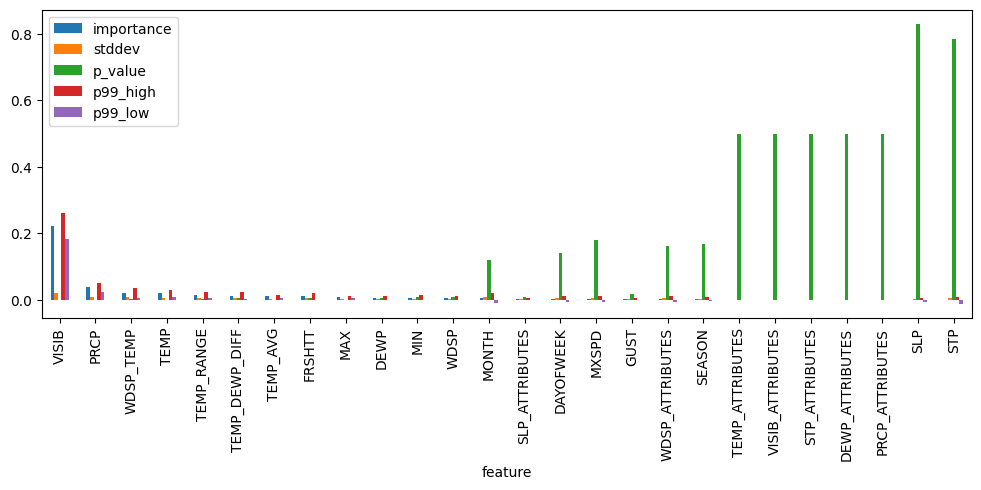

In [18]:
# View and Plot Feature Importance... (this various from Scenario to Scenario)
print(AQbyWeather.selectedScenario.getSummary())
display(featureimp_df)
featureimp_df.drop(columns=["n"]).plot(kind="bar", figsize=(12, 4), xlabel="feature")

In [19]:
# Load + Use Our Model (this line is unnecessary, but shows how to load a built model)...
predictor = TabularPredictor.load(AQbyWeather.selectedScenario.getModelPath())

# Make Predictions, which are saved to an array: y_pred
print(AQbyWeather.selectedScenario.getSummary())
y_pred = predictor.predict(test_df)
display(y_pred)

Loading: /Users/changliang.wu/Projects/aws/aqi/aqi_prediction/notebooks/AutogluonModels/aq_los-angeles_pm25_2016-2024/predictor.pkl
Loading: /Users/changliang.wu/Projects/aws/aqi/aqi_prediction/notebooks/AutogluonModels/aq_los-angeles_pm25_2016-2024/learner.pkl
Loading: /Users/changliang.wu/Projects/aws/aqi/aqi_prediction/notebooks/AutogluonModels/aq_los-angeles_pm25_2016-2024/models/trainer.pkl


Scenario: los-angeles_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


Loading: /Users/changliang.wu/Projects/aws/aqi/aqi_prediction/notebooks/AutogluonModels/aq_los-angeles_pm25_2016-2024/models/LightGBM_BAG_L1/T8/model.pkl
Loading: /Users/changliang.wu/Projects/aws/aqi/aqi_prediction/notebooks/AutogluonModels/aq_los-angeles_pm25_2016-2024/models/NeuralNetTorch_BAG_L1/b00e46f8/model.pkl
Loading: /Users/changliang.wu/Projects/aws/aqi/aqi_prediction/notebooks/AutogluonModels/aq_los-angeles_pm25_2016-2024/models/WeightedEnsemble_L2/model.pkl


1208    0
447     1
1460    0
1503    0
1219    0
       ..
1143    1
385     1
1256    0
2055    0
1988    0
Name: isUnhealthy, Length: 530, dtype: int8

In [20]:
# Get true label values as an array: y_true
print(AQbyWeather.selectedScenario.getSummary())
y_true = validate_df[AQbyWeather.mlTargetLabel]
display(y_true)

Scenario: los-angeles_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


1208    0
447     1
1460    0
1503    0
1219    0
       ..
1143    0
385     1
1256    1
2055    0
1988    0
Name: isUnhealthy, Length: 530, dtype: int8

Scenario: los-angeles_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
True Negatives  (TN): 217 of 257 => 84.44%
True Positives  (TP): 205 of 273 => 75.09%
False Negatives (FN): 68 of 273 => 24.91%
False Positives (FP): 40 of 257 => 15.56%


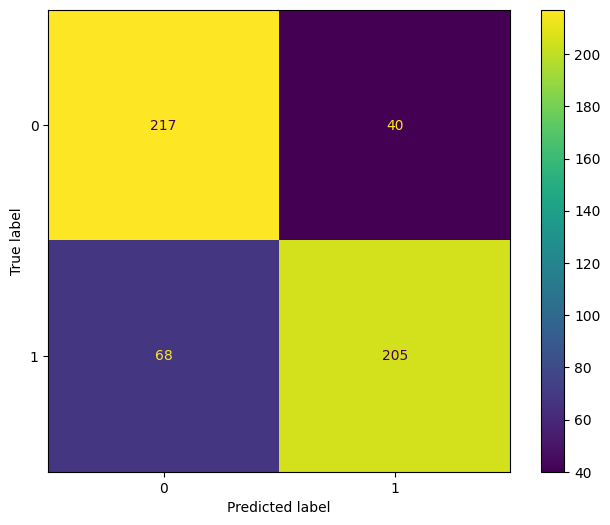

In [21]:
# Get Confusion Matrix (CM), Get Additional CM Data, View CM...
# Learn More: https://towardsdatascience.com/confusion-matrix-what-is-it-e859e1bbecdc
#             https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
print(AQbyWeather.selectedScenario.getSummary())
cm = confusion_matrix(y_true, y_pred)

# Print Confusion Matrix data...
cmData = AQbyWeather.getConfusionMatrixData(cm)
print(cmData.TN_Output)
print(cmData.TP_Output)
print(cmData.FN_Output)
print(cmData.FP_Output)

# Plot Confusion Matrix...
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 6))
cmd.plot(ax=ax)

In [22]:
# Create and save final results...
print(AQbyWeather.selectedScenario.getSummary())
resultsFile = AQbyWeather.getFilenameOther("dataRESULTS")
results_df = pd.DataFrame()
results_df['PREDICTION'] = pd.DataFrame(y_pred)
results_df = pd.concat([validate_df, results_df], axis=1)
results_df.to_csv(resultsFile, index=False)
print(f"Results saved to {resultsFile}. DONE.")
display(results_df)

Scenario: los-angeles_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Results saved to dataRESULTS_los-angeles_pm25_2016-2024.csv. DONE.


,TEMP,TEMP_ATTRIBUTES,DEWP,DEWP_ATTRIBUTES,SLP,SLP_ATTRIBUTES,STP,STP_ATTRIBUTES,VISIB,VISIB_ATTRIBUTES,...,MONTH,DAYOFWEEK,TEMP_RANGE,TEMP_AVG,TEMP_DEWP_DIFF,WDSP_TEMP,isUnhealthy,PRCP_ATTRIBUTES,SEASON,PREDICTION
1208,63.2,24,52.0,24,1017.3,24,10.8,24,10.0,24,...,10,5,15.2,63.50,11.50,76.200,0,1,0,0
447,73.2,24,62.7,24,1012.4,23,5.9,24,7.2,24,...,8,6,20.0,74.90,12.20,134.820,1,0,2,1
1460,66.0,24,52.8,24,1011.3,24,4.8,24,10.0,24,...,6,5,16.9,67.45,14.65,107.920,0,0,2,0
1503,75.0,24,62.9,24,1014.2,24,7.9,24,10.0,24,...,7,6,20.0,76.00,13.10,83.600,0,0,2,0
1219,60.8,24,49.4,24,1017.8,24,11.2,24,10.0,24,...,10,2,18.0,62.10,12.70,80.730,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,73.3,24,59.6,23,1011.5,24,5.2,24,7.0,24,...,8,2,24.2,77.00,17.40,115.500,0,0,2,1
385,66.7,24,57.0,24,1013.5,24,6.9,24,8.8,24,...,5,1,21.9,71.05,14.05,113.680,1,0,1,1
1256,60.0,24,21.2,24,1020.9,24,14.3,24,10.0,24,...,11,4,29.0,61.40,40.20,36.840,1,0,0,0
2055,62.3,24,49.1,24,1017.0,24,10.4,24,10.0,24,...,3,0,23.0,63.50,14.40,76.200,0,0,1,0
